In [1]:
!pip install -q kaggle timm h5py torchmetrics tqdm seaborn matplotlib scikit-learn torchinfo

import os
import json
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score,
    MulticlassAUROC,
    MulticlassMatthewsCorrCoef
)

from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 26.1 MB/s eta 0:00:00
Using device: cuda


In [2]:
KAGGLE_USERNAME = "YOUR_USERNAME"
KAGGLE_KEY = "YOUR_KEY"

os.makedirs("/root/.config/kaggle", exist_ok=True)
with open("/root/.config/kaggle/kaggle.json", "w") as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)
os.chmod("/root/.config/kaggle/kaggle.json", 0o600)


In [3]:
from kaggle.api.kaggle_api_extended import KaggleApi

DATA_DIR = "brain_tumor_44c"
DATASET = "fernando2rad/brain-tumor-mri-images-44c"

if not os.path.exists(DATA_DIR):
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files(DATASET, path=DATA_DIR, unzip=True)

print("Dataset downloaded to:", DATA_DIR)


Dataset URL: https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c
Dataset downloaded to: brain_tumor_44c


In [4]:
from pathlib import Path

IMAGE_EXTS = (".jpg", ".jpeg", ".png")

paths, labels = [], []

# Collect class folders
class_dirs = []
for root, dirs, files in os.walk(DATA_DIR):
    if any(f.lower().endswith(IMAGE_EXTS) for f in files):
        class_dirs.append(root)

class_dirs = sorted(class_dirs)

class_to_idx = {Path(d).name: idx for idx, d in enumerate(class_dirs)}
idx_to_class = {v: k for k, v in class_to_idx.items()}

print("Number of classes:", len(class_to_idx))

for root, _, files in os.walk(DATA_DIR):
    class_name = Path(root).name
    if class_name not in class_to_idx:
        continue

    label = class_to_idx[class_name]

    for f in files:
        if f.lower().endswith(IMAGE_EXTS):
            paths.append(os.path.join(root, f))
            labels.append(label)

df = pd.DataFrame({
    "image_path": paths,
    "label": labels
})

print("Total images:", len(df))
print("Class distribution:\n", df["label"].value_counts().sort_index())

num_classes = df["label"].nunique()


Number of classes: 44
Total images: 4478
Class distribution:
 label
0     176
1     232
2     171
3      66
4     112
5      73
6      45
7      48
8      57
9      20
10     18
11     23
12     27
13     40
14     33
15     55
16     94
17     55
18     30
19     31
20     17
21     23
22     67
23     41
24    272
25    369
26    233
27    130
28    223
29    104
30     86
31     72
32     66
33     66
34    108
35     63
36    148
37    194
38    123
39     28
40     84
41     33
42    251
43    271
Name: count, dtype: int64


In [5]:
train_df, test_df = train_test_split(
    df, stratify=df.label, test_size=0.2, random_state=42
)

train_df, val_df = train_test_split(
    train_df, stratify=train_df.label, test_size=0.2, random_state=42
)

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))


Train: 2865
Val: 717
Test: 896


In [6]:
class BrainTumorDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "image_path"]
        label = self.df.loc[idx, "label"]

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        return image, label


In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 224 is fine for base
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])


In [8]:
train_loader = DataLoader(
    BrainTumorDataset(train_df, transform),
    batch_size=16,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    BrainTumorDataset(val_df, transform),
    batch_size=16,
    num_workers=2
)

test_loader = DataLoader(
    BrainTumorDataset(test_df, transform),
    batch_size=16,
    num_workers=2
)


In [9]:
import timm

model = timm.create_model(
    "convnextv2_base.fcmae_ft_in22k_in1k",
    pretrained=True,
    num_classes=num_classes
)

model = model.to(device)

print("Model loaded successfully")


summary(model, input_size=(1,3,224,224))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/355M [00:00<?, ?B/s]

Model loaded successfully


Layer (type:depth-idx)                                       Output Shape              Param #
ConvNeXt                                                     [1, 44]                   --
├─Sequential: 1-1                                            [1, 128, 56, 56]          --
│    └─Conv2d: 2-1                                           [1, 128, 56, 56]          6,272
│    └─LayerNorm2d: 2-2                                      [1, 128, 56, 56]          256
├─Sequential: 1-2                                            [1, 1024, 7, 7]           --
│    └─ConvNeXtStage: 2-3                                    [1, 128, 56, 56]          --
│    │    └─Identity: 3-1                                    [1, 128, 56, 56]          --
│    │    └─Sequential: 3-2                                  [1, 128, 56, 56]          418,176
│    └─ConvNeXtStage: 2-4                                    [1, 256, 28, 28]          --
│    │    └─Sequential: 3-3                                  [1, 256, 28, 28]         

In [10]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-4
)

EPOCHS = 30
patience = 5

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS
)


In [11]:
def get_metrics():
    return {
        "acc": MulticlassAccuracy(num_classes=num_classes).to(device),
        "precision": MulticlassPrecision(num_classes=num_classes, average="macro").to(device),
        "recall": MulticlassRecall(num_classes=num_classes, average="macro").to(device),
        "f1": MulticlassF1Score(num_classes=num_classes, average="macro").to(device),
        "auc": MulticlassAUROC(num_classes=num_classes).to(device),
        "mcc": MulticlassMatthewsCorrCoef(num_classes=num_classes).to(device)
    }

def multiclass_specificity_sensitivity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    spec, sens = [], []

    for i in range(num_classes):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        tn = cm.sum() - (tp+fp+fn)

        spec.append(tn/(tn+fp+1e-8))
        sens.append(tp/(tp+fn+1e-8))

    return float(np.mean(spec)), float(np.mean(sens))


In [12]:
from PIL import Image


In [14]:
history = {
    "loss": [], "val_loss": [],
    "accuracy": [], "val_accuracy": [],
    "precision": [], "val_precision": [],
    "recall": [], "val_recall": [],
    "f1": [], "val_f1": [],
    "specificity": [], "val_specificity": [],
    "sensitivity": [], "val_sensitivity": [],
    "mcc": [], "val_mcc": [],
    "auc": [], "val_auc": []
}

best_val_loss = float("inf")
counter = 0

for epoch in range(EPOCHS):

    # ================= TRAIN =================
    model.train()
    train_loss = 0
    train_preds, train_targets = [], []
    train_metrics = get_metrics()

    pbar = tqdm(train_loader, desc=f"Training - Epoch [{epoch+1}/{EPOCHS}]")

    for x, y in pbar:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = out.argmax(1)

        train_preds.append(preds.cpu())
        train_targets.append(y.cpu())

        for m in train_metrics.values():
            m.update(out, y)

    train_loss /= len(train_loader)

    train_preds = torch.cat(train_preds).numpy()
    train_targets = torch.cat(train_targets).numpy()

    train_spec, train_sens = multiclass_specificity_sensitivity(train_targets, train_preds)
    train_out = {k: v.compute().item() for k, v in train_metrics.items()}

    print(f"\n===== Epoch {epoch+1} TRAIN =====")
    print(f"Loss: {train_loss:.4f}")
    print(f"Acc: {train_out['acc']:.4f} | Prec: {train_out['precision']:.4f} | "
          f"Recall: {train_out['recall']:.4f} | F1: {train_out['f1']:.4f}")
    print(f"Spec: {train_spec:.4f} | Sens: {train_sens:.4f} | "
          f"MCC: {train_out['mcc']:.4f} | AUC: {train_out['auc']:.4f}")

    # ================= VALID =================
    model.eval()
    val_loss = 0
    val_preds, val_targets = [], []
    val_metrics = get_metrics()

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc="Validating"):
            x, y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item()

            preds = out.argmax(1)
            val_preds.append(preds.cpu())
            val_targets.append(y.cpu())

            for m in val_metrics.values():
                m.update(out, y)

    val_loss /= len(val_loader)

    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()

    val_spec, val_sens = multiclass_specificity_sensitivity(val_targets, val_preds)
    val_out = {k: v.compute().item() for k, v in val_metrics.items()}

    print(f"\n===== Epoch {epoch+1} VALID =====")
    print(f"Loss: {val_loss:.4f}")
    print(f"Acc: {val_out['acc']:.4f} | Prec: {val_out['precision']:.4f} | "
          f"Recall: {val_out['recall']:.4f} | F1: {val_out['f1']:.4f}")
    print(f"Spec: {val_spec:.4f} | Sens: {val_sens:.4f} | "
          f"MCC: {val_out['mcc']:.4f} | AUC: {val_out['auc']:.4f}")

    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6e}\n")

    scheduler.step()

    # ================= SAVE HISTORY =================
    history["loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["accuracy"].append(train_out["acc"])
    history["val_accuracy"].append(val_out["acc"])
    history["precision"].append(train_out["precision"])
    history["val_precision"].append(val_out["precision"])
    history["recall"].append(train_out["recall"])
    history["val_recall"].append(val_out["recall"])
    history["f1"].append(train_out["f1"])
    history["val_f1"].append(val_out["f1"])
    history["specificity"].append(train_spec)
    history["val_specificity"].append(val_spec)
    history["sensitivity"].append(train_sens)
    history["val_sensitivity"].append(val_sens)
    history["mcc"].append(train_out["mcc"])
    history["val_mcc"].append(val_out["mcc"])
    history["auc"].append(train_out["auc"])
    history["val_auc"].append(val_out["auc"])

    # ================= EARLY STOPPING =================
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_convnextv2_44c.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Training - Epoch [1/30]: 100%|██████████| 180/180 [02:39<00:00,  1.13it/s]



===== Epoch 1 TRAIN =====
Loss: 3.5657
Acc: 0.0224 | Prec: 0.0085 | Recall: 0.0224 | F1: 0.0107
Spec: 0.9773 | Sens: 0.0224 | MCC: -0.0000 | AUC: 0.4643


Validating: 100%|██████████| 45/45 [00:12<00:00,  3.54it/s]



===== Epoch 1 VALID =====
Loss: 3.5147
Acc: 0.0227 | Prec: 0.0014 | Recall: 0.0227 | F1: 0.0026
Spec: 0.9773 | Sens: 0.0227 | MCC: 0.0000 | AUC: 0.4974
Current LR: 5.000000e-04



Training - Epoch [2/30]: 100%|██████████| 180/180 [02:44<00:00,  1.10it/s]



===== Epoch 2 TRAIN =====
Loss: 3.5156
Acc: 0.0238 | Prec: 0.0074 | Recall: 0.0238 | F1: 0.0105
Spec: 0.9774 | Sens: 0.0238 | MCC: 0.0048 | AUC: 0.4547


Validating: 100%|██████████| 45/45 [00:11<00:00,  3.99it/s]



===== Epoch 2 VALID =====
Loss: 3.4877
Acc: 0.0227 | Prec: 0.0019 | Recall: 0.0227 | F1: 0.0035
Spec: 0.9773 | Sens: 0.0227 | MCC: 0.0000 | AUC: 0.5581
Current LR: 4.986305e-04



Training - Epoch [3/30]: 100%|██████████| 180/180 [02:44<00:00,  1.09it/s]



===== Epoch 3 TRAIN =====
Loss: 3.5042
Acc: 0.0228 | Prec: 0.0081 | Recall: 0.0228 | F1: 0.0083
Spec: 0.9773 | Sens: 0.0228 | MCC: -0.0007 | AUC: 0.4619


Validating: 100%|██████████| 45/45 [00:11<00:00,  4.07it/s]



===== Epoch 3 VALID =====
Loss: 3.4909
Acc: 0.0227 | Prec: 0.0019 | Recall: 0.0227 | F1: 0.0035
Spec: 0.9773 | Sens: 0.0227 | MCC: 0.0000 | AUC: 0.5362
Current LR: 4.945369e-04



Training - Epoch [4/30]: 100%|██████████| 180/180 [02:44<00:00,  1.10it/s]



===== Epoch 4 TRAIN =====
Loss: 3.5068
Acc: 0.0212 | Prec: 0.0054 | Recall: 0.0212 | F1: 0.0081
Spec: 0.9772 | Sens: 0.0212 | MCC: -0.0062 | AUC: 0.4544


Validating: 100%|██████████| 45/45 [00:11<00:00,  4.07it/s]



===== Epoch 4 VALID =====
Loss: 3.4894
Acc: 0.0227 | Prec: 0.0019 | Recall: 0.0227 | F1: 0.0035
Spec: 0.9773 | Sens: 0.0227 | MCC: 0.0000 | AUC: 0.4987
Current LR: 4.877641e-04



Training - Epoch [5/30]: 100%|██████████| 180/180 [02:44<00:00,  1.10it/s]



===== Epoch 5 TRAIN =====
Loss: 3.5070
Acc: 0.0236 | Prec: 0.0043 | Recall: 0.0236 | F1: 0.0067
Spec: 0.9773 | Sens: 0.0236 | MCC: 0.0039 | AUC: 0.4542


Validating: 100%|██████████| 45/45 [00:10<00:00,  4.09it/s]



===== Epoch 5 VALID =====
Loss: 3.4877
Acc: 0.0227 | Prec: 0.0019 | Recall: 0.0227 | F1: 0.0035
Spec: 0.9773 | Sens: 0.0227 | MCC: 0.0000 | AUC: 0.4884
Current LR: 4.783864e-04



Training - Epoch [6/30]: 100%|██████████| 180/180 [02:44<00:00,  1.09it/s]



===== Epoch 6 TRAIN =====
Loss: 3.5029
Acc: 0.0227 | Prec: 0.0019 | Recall: 0.0227 | F1: 0.0035
Spec: 0.9773 | Sens: 0.0227 | MCC: 0.0000 | AUC: 0.4722


Validating: 100%|██████████| 45/45 [00:11<00:00,  4.08it/s]



===== Epoch 6 VALID =====
Loss: 3.4873
Acc: 0.0227 | Prec: 0.0019 | Recall: 0.0227 | F1: 0.0035
Spec: 0.9773 | Sens: 0.0227 | MCC: 0.0000 | AUC: 0.5046
Current LR: 4.665064e-04



Training - Epoch [7/30]: 100%|██████████| 180/180 [02:44<00:00,  1.09it/s]



===== Epoch 7 TRAIN =====
Loss: 3.5051
Acc: 0.0228 | Prec: 0.0031 | Recall: 0.0228 | F1: 0.0048
Spec: 0.9773 | Sens: 0.0228 | MCC: 0.0015 | AUC: 0.4519


Validating: 100%|██████████| 45/45 [00:11<00:00,  4.01it/s]



===== Epoch 7 VALID =====
Loss: 3.4815
Acc: 0.0227 | Prec: 0.0019 | Recall: 0.0227 | F1: 0.0035
Spec: 0.9773 | Sens: 0.0227 | MCC: 0.0000 | AUC: 0.5206
Current LR: 4.522542e-04



Training - Epoch [8/30]: 100%|██████████| 180/180 [02:44<00:00,  1.10it/s]



===== Epoch 8 TRAIN =====
Loss: 3.4979
Acc: 0.0215 | Prec: 0.0031 | Recall: 0.0215 | F1: 0.0053
Spec: 0.9772 | Sens: 0.0215 | MCC: -0.0062 | AUC: 0.4403


Validating: 100%|██████████| 45/45 [00:10<00:00,  4.10it/s]



===== Epoch 8 VALID =====
Loss: 3.4826
Acc: 0.0227 | Prec: 0.0019 | Recall: 0.0227 | F1: 0.0035
Spec: 0.9773 | Sens: 0.0227 | MCC: 0.0000 | AUC: 0.5029
Current LR: 4.357862e-04



Training - Epoch [9/30]: 100%|██████████| 180/180 [02:43<00:00,  1.10it/s]



===== Epoch 9 TRAIN =====
Loss: 3.4937
Acc: 0.0226 | Prec: 0.0031 | Recall: 0.0226 | F1: 0.0052
Spec: 0.9773 | Sens: 0.0226 | MCC: -0.0005 | AUC: 0.4474


Validating: 100%|██████████| 45/45 [00:10<00:00,  4.10it/s]



===== Epoch 9 VALID =====
Loss: 3.4833
Acc: 0.0227 | Prec: 0.0019 | Recall: 0.0227 | F1: 0.0035
Spec: 0.9773 | Sens: 0.0227 | MCC: 0.0000 | AUC: 0.5324
Current LR: 4.172827e-04



Training - Epoch [10/30]: 100%|██████████| 180/180 [02:44<00:00,  1.10it/s]



===== Epoch 10 TRAIN =====
Loss: 3.4948
Acc: 0.0224 | Prec: 0.0040 | Recall: 0.0224 | F1: 0.0047
Spec: 0.9773 | Sens: 0.0224 | MCC: -0.0031 | AUC: 0.4568


Validating: 100%|██████████| 45/45 [00:11<00:00,  3.99it/s]



===== Epoch 10 VALID =====
Loss: 3.4840
Acc: 0.0227 | Prec: 0.0019 | Recall: 0.0227 | F1: 0.0035
Spec: 0.9773 | Sens: 0.0227 | MCC: 0.0000 | AUC: 0.5082
Current LR: 3.969463e-04



Training - Epoch [11/30]: 100%|██████████| 180/180 [02:44<00:00,  1.10it/s]



===== Epoch 11 TRAIN =====
Loss: 3.5008
Acc: 0.0227 | Prec: 0.0019 | Recall: 0.0227 | F1: 0.0035
Spec: 0.9773 | Sens: 0.0227 | MCC: 0.0000 | AUC: 0.4551


Validating: 100%|██████████| 45/45 [00:11<00:00,  4.09it/s]



===== Epoch 11 VALID =====
Loss: 3.4871
Acc: 0.0227 | Prec: 0.0019 | Recall: 0.0227 | F1: 0.0035
Spec: 0.9773 | Sens: 0.0227 | MCC: 0.0000 | AUC: 0.5459
Current LR: 3.750000e-04



Training - Epoch [12/30]: 100%|██████████| 180/180 [02:44<00:00,  1.10it/s]



===== Epoch 12 TRAIN =====
Loss: 3.4977
Acc: 0.0227 | Prec: 0.0019 | Recall: 0.0227 | F1: 0.0035
Spec: 0.9773 | Sens: 0.0227 | MCC: 0.0000 | AUC: 0.4526


Validating: 100%|██████████| 45/45 [00:11<00:00,  4.05it/s]


===== Epoch 12 VALID =====
Loss: 3.4816
Acc: 0.0227 | Prec: 0.0019 | Recall: 0.0227 | F1: 0.0035
Spec: 0.9773 | Sens: 0.0227 | MCC: 0.0000 | AUC: 0.5346
Current LR: 3.516842e-04

Early stopping triggered.


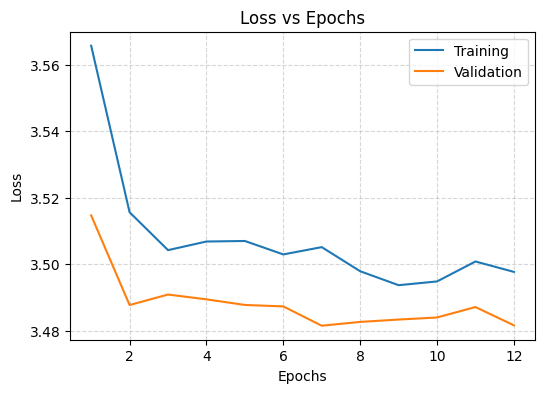

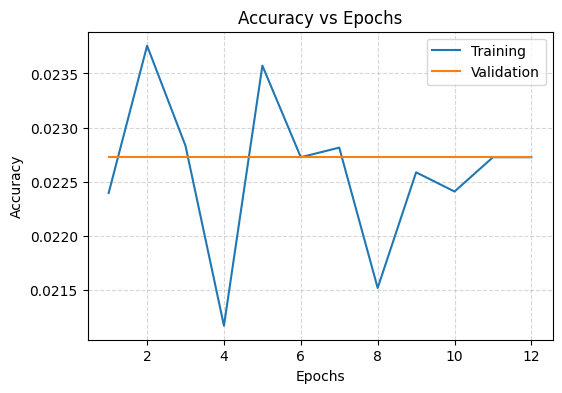

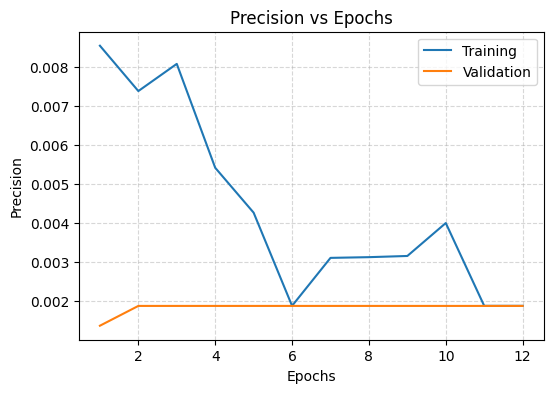

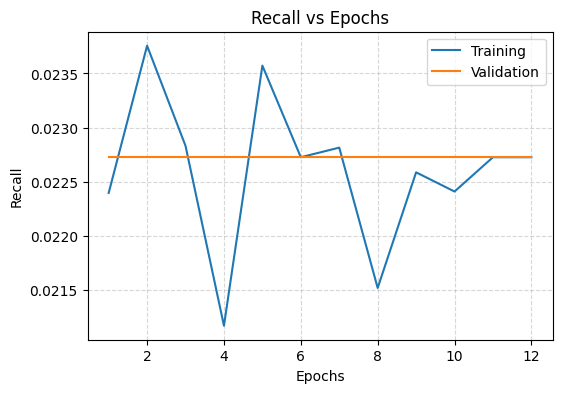

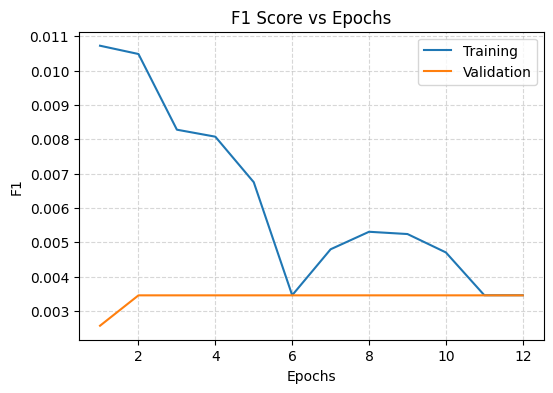

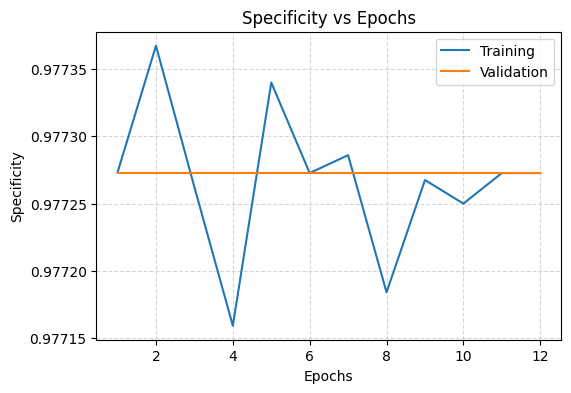

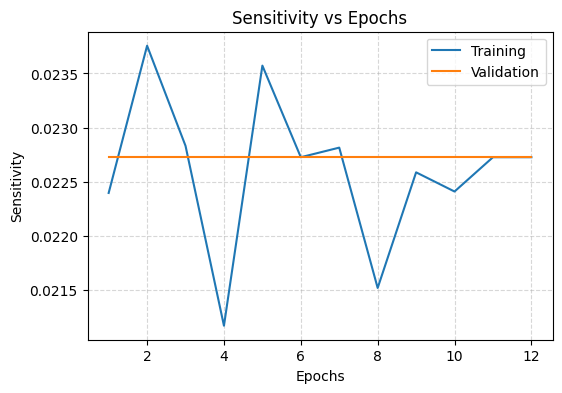

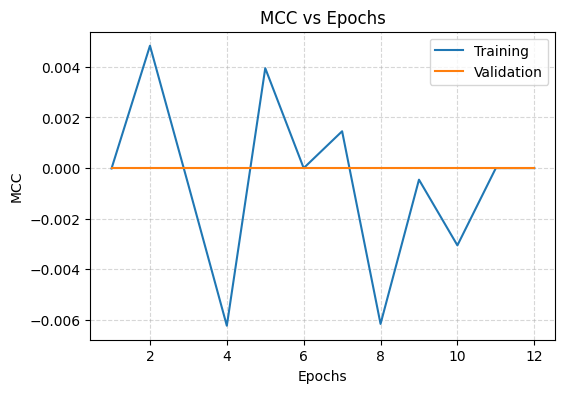

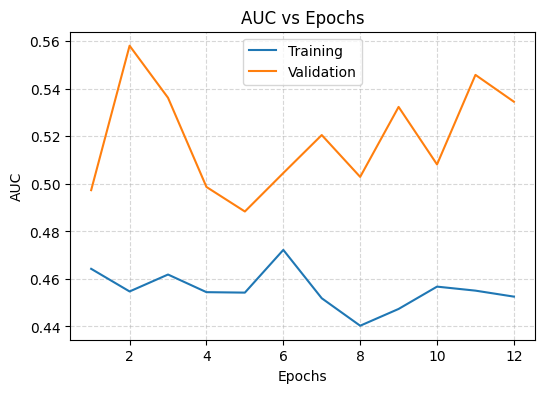

In [15]:
def plot_metric(train, val, title, ylabel):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train, label="Training")
    plt.plot(epochs, val, label="Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

plot_metric(history["loss"], history["val_loss"], "Loss vs Epochs", "Loss")
plot_metric(history["accuracy"], history["val_accuracy"], "Accuracy vs Epochs", "Accuracy")
plot_metric(history["precision"], history["val_precision"], "Precision vs Epochs", "Precision")
plot_metric(history["recall"], history["val_recall"], "Recall vs Epochs", "Recall")
plot_metric(history["f1"], history["val_f1"], "F1 Score vs Epochs", "F1")
plot_metric(history["specificity"], history["val_specificity"], "Specificity vs Epochs", "Specificity")
plot_metric(history["sensitivity"], history["val_sensitivity"], "Sensitivity vs Epochs", "Sensitivity")
plot_metric(history["mcc"], history["val_mcc"], "MCC vs Epochs", "MCC")
plot_metric(history["auc"], history["val_auc"], "AUC vs Epochs", "AUC")


In [17]:
if os.path.exists("best_convnextv2_44c.pth"):
    model.load_state_dict(torch.load("best_convnextv2_44c.pth"))
    print("Best model loaded.")
else:
    print("No saved model found.")


Best model loaded.


In [16]:
# Load best model
model.load_state_dict(torch.load("best_convnextv2_44c.pth"))

model.eval()


ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): GlobalResponseNormMlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (grn): GlobalResponseNorm()
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), strid

In [18]:
test_metrics = get_metrics()
test_loss = 0
all_preds, all_targets = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x, y = x.to(device), y.to(device)

        out = model(x)
        loss = criterion(out, y)
        test_loss += loss.item()

        preds = out.argmax(1)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

        for m in test_metrics.values():
            m.update(out, y)

test_loss /= len(test_loader)

print("\n===== TEST RESULTS =====")
print(f"Test Loss: {test_loss:.4f}")

for k, v in test_metrics.items():
    print(f"{k.upper()}: {v.compute().item():.4f}")


Testing: 100%|██████████| 56/56 [00:13<00:00,  4.09it/s]


===== TEST RESULTS =====
Test Loss: 3.4840
ACC: 0.0227
PRECISION: 0.0019
RECALL: 0.0227
F1: 0.0035
AUC: 0.5224
MCC: 0.0000


In [19]:
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

print("\n===== CLASSIFICATION REPORT =====\n")
print(classification_report(all_targets, all_preds, digits=4))



===== CLASSIFICATION REPORT =====

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        35
           1     0.0000    0.0000    0.0000        46
           2     0.0000    0.0000    0.0000        34
           3     0.0000    0.0000    0.0000        13
           4     0.0000    0.0000    0.0000        22
           5     0.0000    0.0000    0.0000        15
           6     0.0000    0.0000    0.0000         9
           7     0.0000    0.0000    0.0000        10
           8     0.0000    0.0000    0.0000        11
           9     0.0000    0.0000    0.0000         4
          10     0.0000    0.0000    0.0000         3
          11     0.0000    0.0000    0.0000         5
          12     0.0000    0.0000    0.0000         5
          13     0.0000    0.0000    0.0000         8
          14     0.0000    0.0000    0.0000         7
          15     0.0000    0.0000    0.0000        11
          16     0.0000    0.0000    0.0000  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


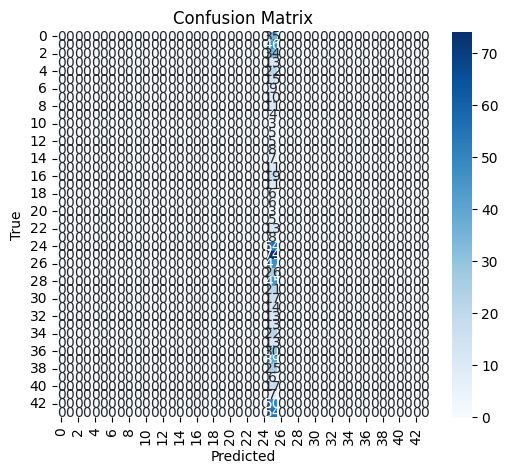

In [20]:
cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [21]:
def plot_metric(train, val, title, ylabel):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train, label="Training")
    plt.plot(epochs, val, label="Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


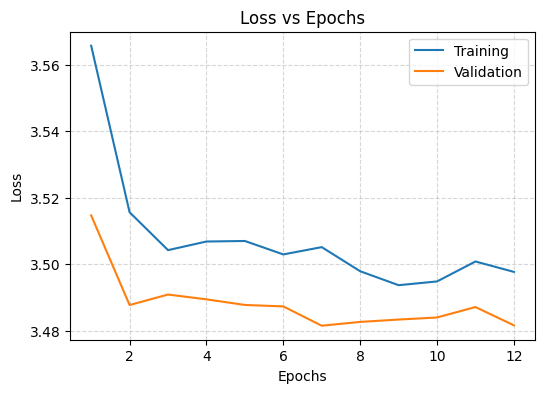

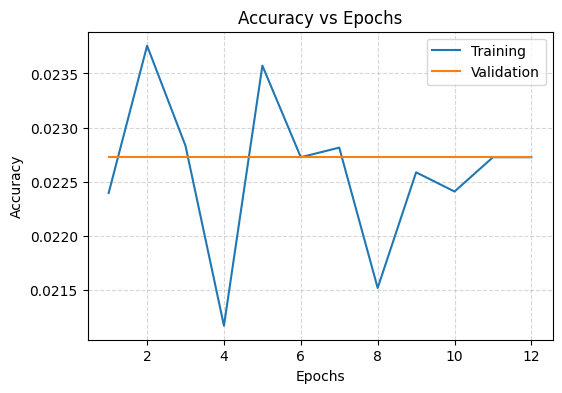

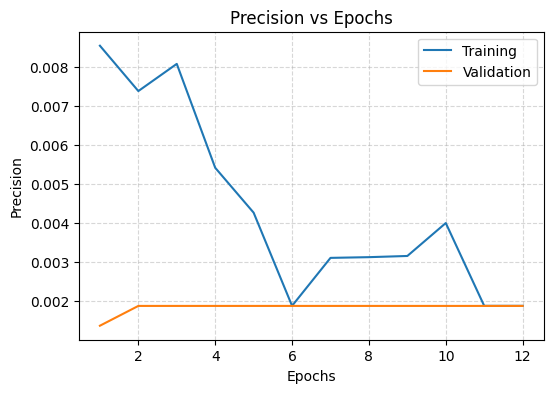

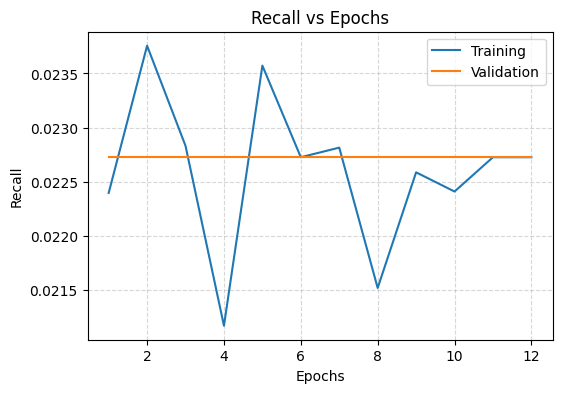

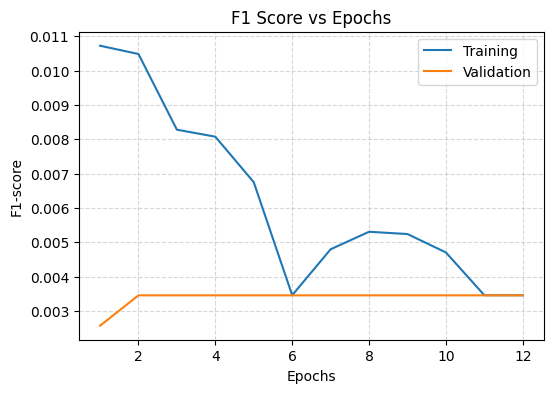

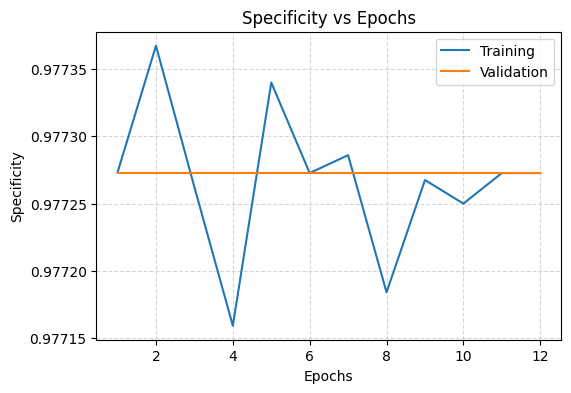

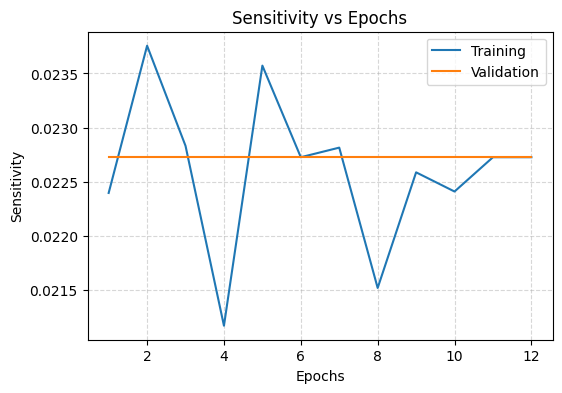

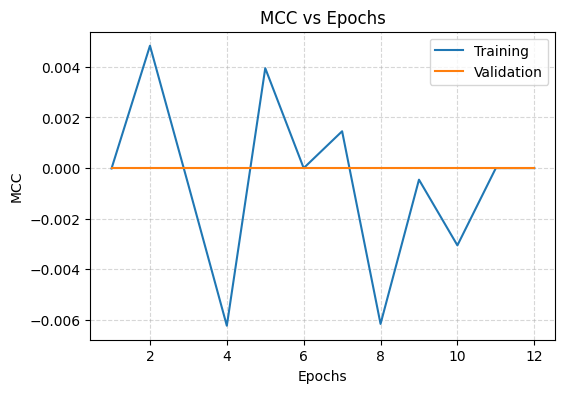

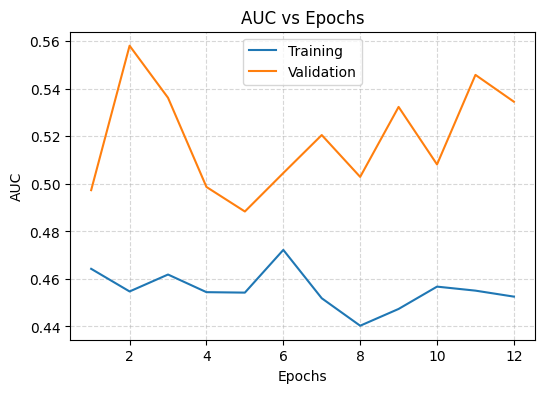

In [22]:
plot_metric(history["loss"], history["val_loss"], "Loss vs Epochs", "Loss")
plot_metric(history["accuracy"], history["val_accuracy"], "Accuracy vs Epochs", "Accuracy")
plot_metric(history["precision"], history["val_precision"], "Precision vs Epochs", "Precision")
plot_metric(history["recall"], history["val_recall"], "Recall vs Epochs", "Recall")
plot_metric(history["f1"], history["val_f1"], "F1 Score vs Epochs", "F1-score")
plot_metric(history["specificity"], history["val_specificity"], "Specificity vs Epochs", "Specificity")
plot_metric(history["sensitivity"], history["val_sensitivity"], "Sensitivity vs Epochs", "Sensitivity")
plot_metric(history["mcc"], history["val_mcc"], "MCC vs Epochs", "MCC")
plot_metric(history["auc"], history["val_auc"], "AUC vs Epochs", "AUC")
